In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.special
import scipy.stats as sts

# Прогнозирование средней номинальной заработной платы в России. 
___
В рамках данной задачи мы будем анализировать получаемое вознаграждение за период январь 1993 — сентябрь 2018. В результате построения модели временного ряда попробуем спрогнозировать номинальную заработную плату на ближайшие два года.

Данные представляют собой значения номинальной заработной платы по стране взятые на конец месяца в рублях в месяц.

In [2]:
df = pd.read_csv('data/WAG_C_M.csv', sep=';',
                 index_col='month', parse_dates=['month'],
                 dayfirst=True)
df.columns =['wage']
df.head()

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## Визуальный анализ

Из графика изменения средней номинальной заработной платы видно, что присутствует ярко выраженный тренд и сезонность. Тренд, очевидно, обусловлен инфляцией, и может быть скорректирован на процент годовой(месячной) инфляции, однако, в рамках данной задачи мы будем оперировать теми данными что у нас есть.

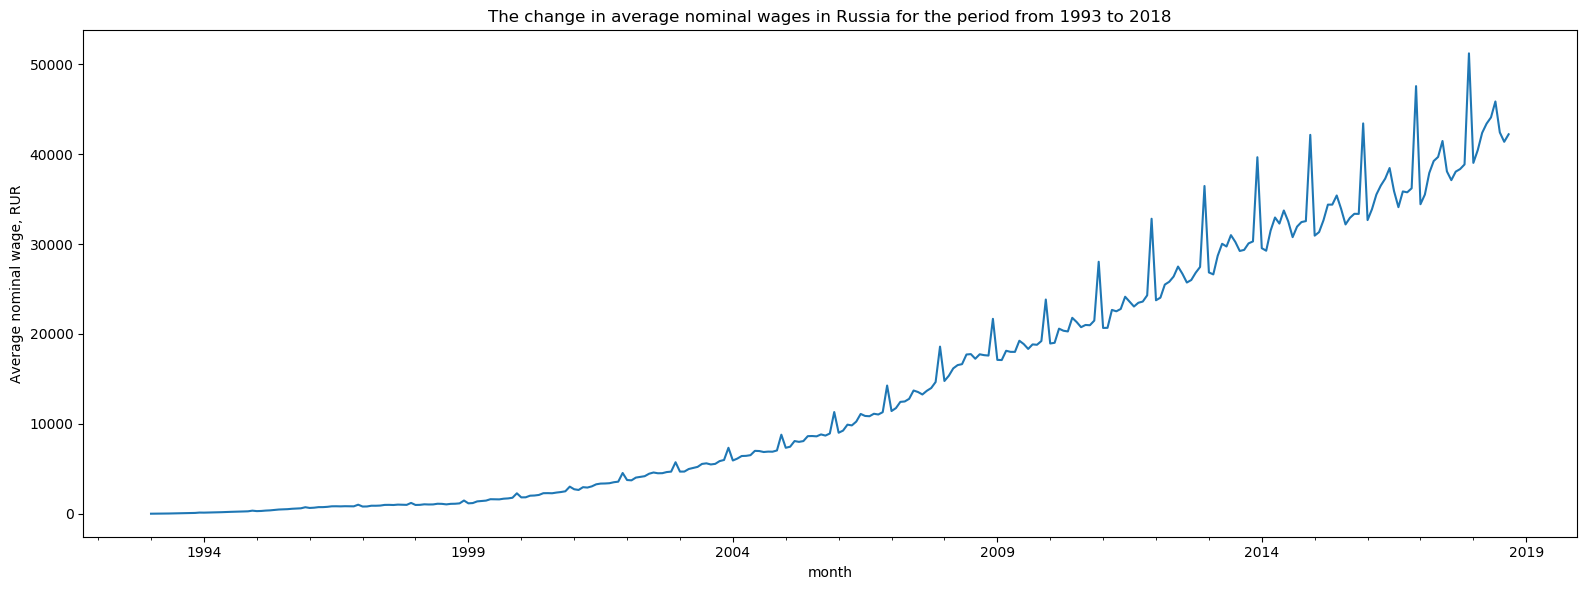

In [3]:
df.wage.plot(figure=plt.figure(figsize=(16,6), dpi=100));
plt.ylabel('Average nominal wage, RUR');
plt.title('The change in average nominal wages in Russia for the period from 1993 to 2018');
plt.tight_layout();

Прогнозирование временного ряд мы будем делать при помощи модели SARIMA. Для того чтобы использовать эту модель, нам необходимо привести данные к стационарному виду и получить начальное приближение для параметров модели. Стационарность подразумевает независмость вида ряда от времени. Для приведения к стационарному виду мы сделаем следующие шаги:
- проверим и стабилизируем дисперсию ряда, если это окажется необходимо;
- дифференцируем ряд для того чтобы избавиться от сезонности и тренда.

## Стабилизация дисперсии

Дисперсия ряда очевидно возрастает к его концу. Применим преобразование Бокса-Кокса для стабилизации дисперсии. Описание метода преобразования есть в Docstring функции. Само преобразование выглядит следующим образом:
$$y_t' = \begin{cases} \log(y_t), \quad \lambda =0 \\(y_t^\lambda - 1) / \lambda, \quad \lambda \ne 0 \end{cases}$$

In [4]:
df['wage_box'], lmbda= sts.boxcox(df.wage)
df.head()

,wage,wage_box
month,,
1993-01-01,15.3,4.101228
1993-02-01,19.1,4.594007
1993-03-01,23.6,5.093465
1993-04-01,30.6,5.748750
1993-05-01,37.5,6.296174


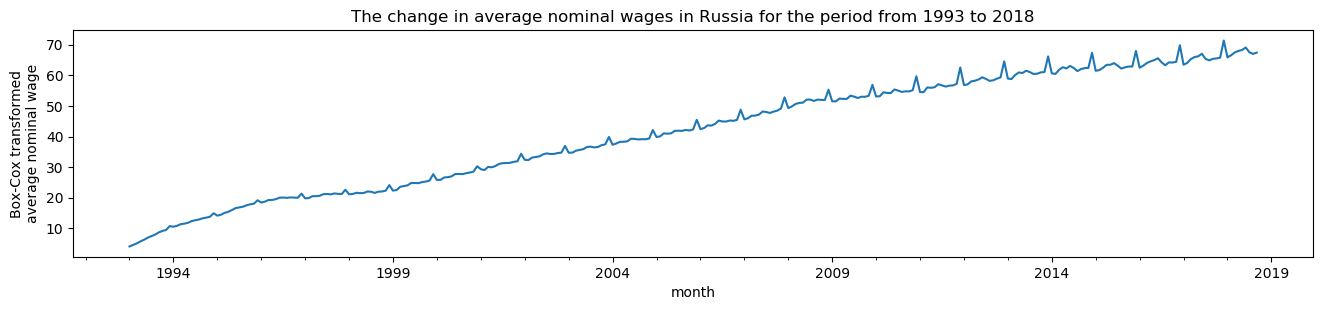

In [5]:
df.wage_box.plot(figure=plt.figure(figsize=(16,3), dpi=100));
plt.ylabel('Box-Cox transformed\naverage nominal wage');
plt.title('The change in average nominal wages in Russia for the period from 1993 to 2018');

## Стационарность. Дифференцирование

Ряд все еще имеет тренд и выраженную сезонность. Используем сезонное дифференцирование.

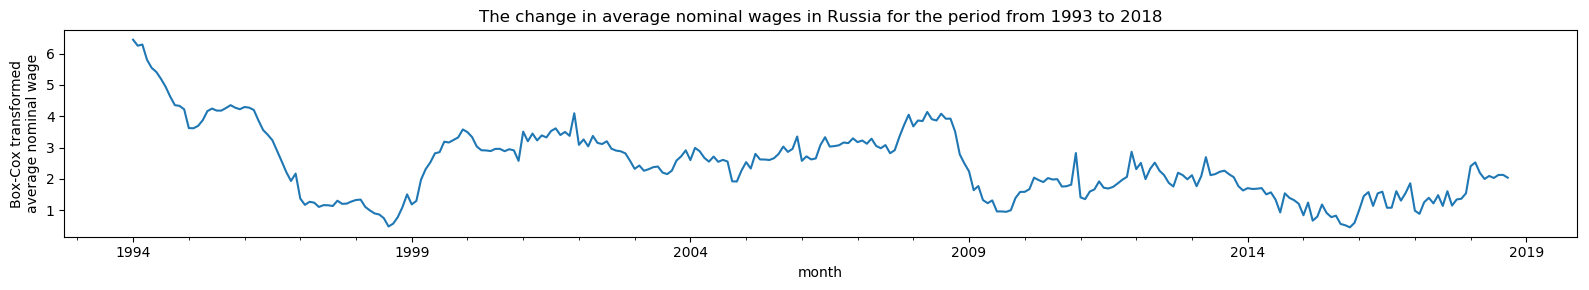

In [6]:
df['wage_box_diff12'] = df.wage_box - df.wage_box.shift(12)

df.wage_box_diff12.plot(figure=plt.figure(figsize=(16, 3), dpi=100))
plt.ylabel('Box-Cox transformed\naverage nominal wage');
plt.title('The change in average nominal wages in Russia for the period from 1993 to 2018');
plt.tight_layout();

Кажется, тренд исчез. Проверим стационарность ряда при помощи критерия Дики-Фуллера. Проверяется гипотеза:  
- $H_0:$ ряд нестационарен. Против общей альтернативы:
- $H_1:$ ряд стационарен

Достигаемый уровень значимости показывает, что ряд всё еще нестационарен.

In [7]:
adfuller_p_val = sm.tsa.stattools.adfuller(df.wage_box_diff12.dropna())[1]
print(f'Достигаемый уровень значимости критерия Дики-Фуллера p_value = {adfuller_p_val:.4f}')

Достигаемый уровень значимости критерия Дики-Фуллера p_value = 0.1353


Достигаемый уровень значимости не позволяет нам отвергнуть нулевую гипотезу. Проведем обычное дифференцирование поверх сезонного.

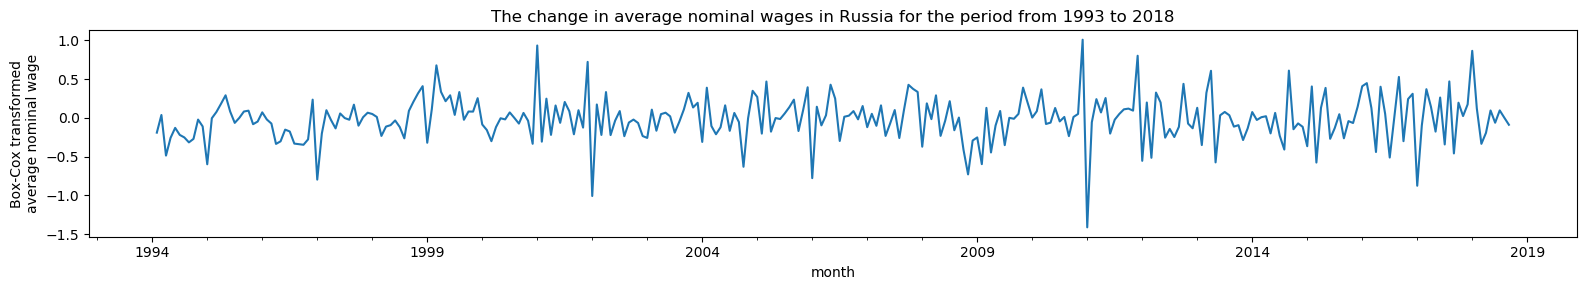

In [8]:
df['wage_box_diff12_1'] = df.wage_box_diff12 - df.wage_box_diff12.shift(1)

df.wage_box_diff12_1.plot(figure=plt.figure(figsize=(16, 3), dpi=100))
plt.ylabel('Box-Cox transformed\naverage nominal wage');
plt.title('The change in average nominal wages in Russia for the period from 1993 to 2018');
plt.tight_layout();

Визуально ряд стал стационарен. Проверим снова при помощи критерия Дики-Фуллера, а также при помощи STL-разложения.

In [9]:
adfuller_p_val = sm.tsa.stattools.adfuller(df.wage_box_diff12_1.dropna())[1]
print(f'Достигаемый уровень значимости критерия Дики-Фуллера p_value = {adfuller_p_val:.9f}')

Достигаемый уровень значимости критерия Дики-Фуллера p_value = 0.000000003


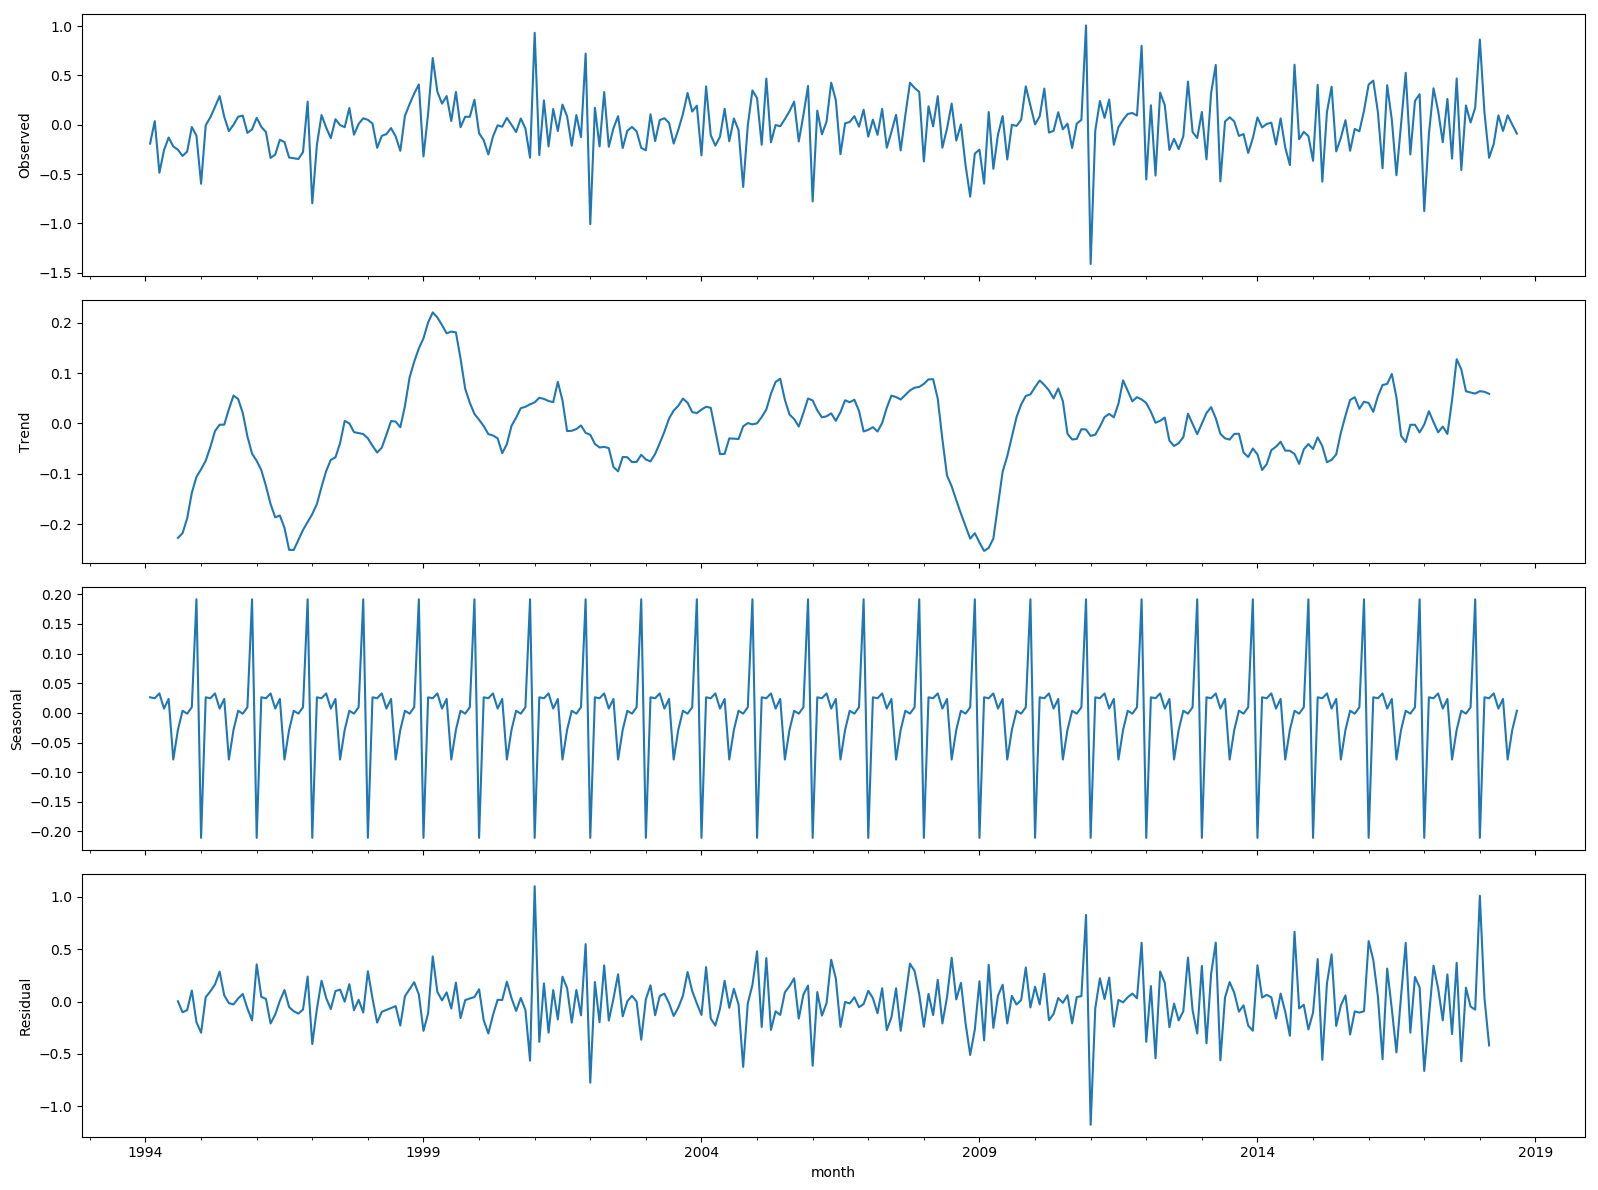

In [10]:
with plt.rc_context({'figure.figsize': (16,12), 'figure.dpi': 100}):
    sm.tsa.seasonal_decompose(df.wage_box_diff12_1.dropna()).plot()

Итак. В резульате преобразования Бокса-Кокса, одного сезонного и одного обычного дифферецирования мы получили стационарный ряд. 

Для прогнозирования мы будем использовать модель $\text{SARIMA}(p,q,d)\times(P,Q,D,S)$. Для этой модели нам уже известны параметры $d=1, D=1, S=12$. Теперь попробуем подобрать начальные приближения параметров p, q, P, Q модели.

## Подбор начальный приближений p, q, P, Q

Начальные приближения подбираются из коррелограмм автокорреляции для q, Q и частичной автокорреляции для p, P. 

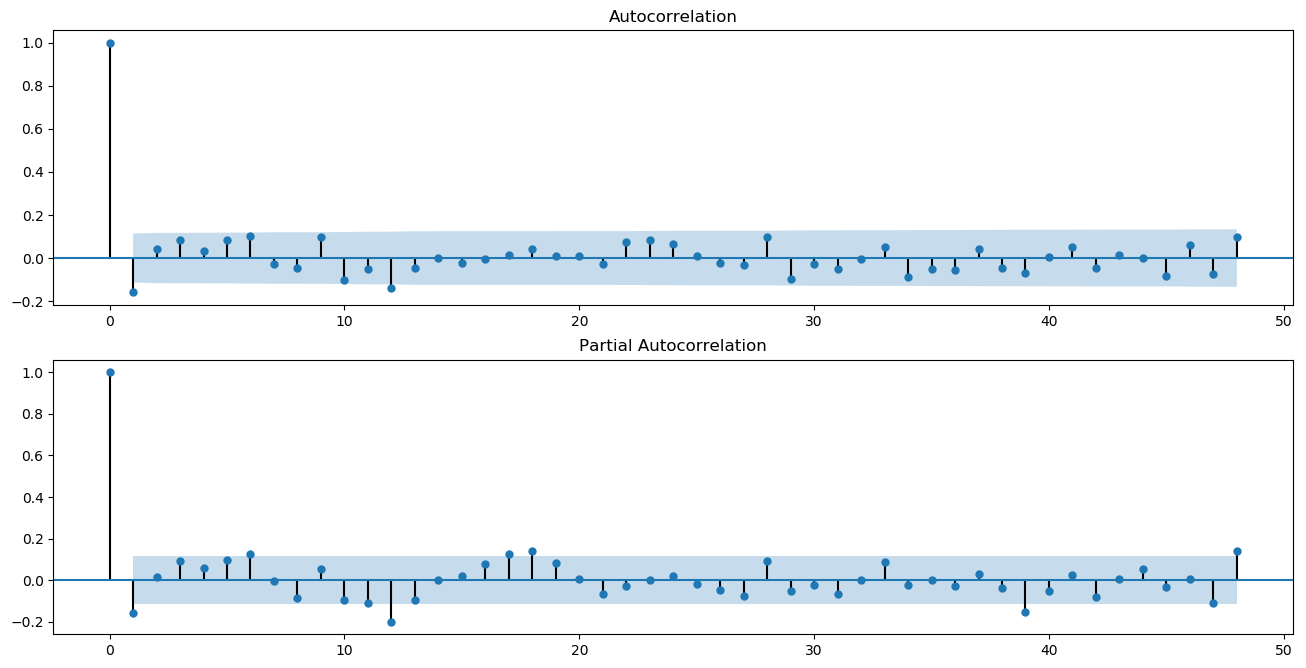

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), dpi=100)

sm.graphics.tsa.plot_acf(
    df.wage_box_diff12_1.dropna().values, lags=48, ax=ax[0])

sm.graphics.tsa.plot_pacf(
    df.wage_box_diff12_1.dropna().values, lags=48, ax=ax[1]);

По полученным графикам мы можем выбрать: 
- По графику автокорреляции: $Q = 1, \quad q = 1$ 
- По графику частичной автокорреляции: $\quad P = \frac{48}{12} = 4, \quad p = 1$ 

## Обучение модели SARIMA

___
*Я подготовил мини-пакет для быстрой сборки модели `sarimax.py`. **Файл должен находиться в одной папке с ноутбуком.** В нём предложенный авторами код для обучения модели, просто положенный для удобства в класс. Его использование похоже на использование sklearn: инициализируете модель с вашими данными в аргументе при помощи `sarimax.SeriesModel(data)`, затем используйте  метод `fit_sarimax()` с вашими начальными параметрами.*

*У результата есть два аттрибута: best_model и results_table. Первый представляет собой обученную модельс лучшим AIC, второй – pandas-таблицу с отсортированными по AIC значениям параметров. Всё как у авторов!*

*Документация написана, смотрите docstring. Здесь я сперва подготовлю модель с его помощью, затем, ниже повтрою то же самое явно, для тех, у кого вдруг не будет работать пакет. Надеюсь это сделает вашу жизнь чуточку удобнее :)*
___

Теперь мы готовы обучить модель. Для неё нам известны параметры  
$S = 12, \quad d = 1, \quad D=1$,  
а также начальные приближения параметров структуры модели:  
$q=1,\quad Q=1,\quad p=1,\quad P=4$.  
Обучаем модель с преобразованием Бокса-Кокса. Дифференцирование модели входит в параметры и произвоидится автоматически.

Стоит отметить, что мы отбросим данные до 1999-го года. т.к. на STL диарамме тренда видно, что он сильно выбивается из привычного. Также, нам известно, что финансовое состояние России сильно отличалось до дефолта 1998-го года. Также вряд ли настолько старые данные могуть помочь в предсказании на ближайшие два года.

In [12]:
import sarimax

In [13]:
%%time
model1 = sarimax.SeriesModel(df.wage_box[72:])
model1.fit_sarimax(p=1, d=1, q=1, P=4, D=1, Q=1, S=12)

CPU times: user 2min 22s, sys: 3.79 s, total: 2min 26s
Wall time: 37.4 s


#### Лучшая модель

In [14]:
print(model1.best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  237
Model:             SARIMAX(0, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 -36.949
Date:                            Thu, 25 Oct 2018   AIC                             87.897
Time:                                    17:50:15   BIC                            111.779
Sample:                                01-01-1999   HQIC                            97.537
                                     - 09-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2952      0.047     -6.219      0.000      -0.388      -0.202
ar.S.L12       0.5745      0.208   

#### Сравнение моделей

In [15]:
print(model1.results_table.head())

      p, q, P, Q        AIC
19  (0, 1, 4, 1)  87.897080
12  (0, 1, 1, 0)  89.067799
13  (0, 1, 1, 1)  89.247051
11  (0, 1, 0, 1)  89.555774
39  (1, 1, 4, 1)  89.834133


___
####  то же самое по авторскому коду


In [16]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

In [17]:
import itertools
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

40

In [18]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    # try except нужен, потому что на некоторых наборах 
    # параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            df.wage_box[96:],
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и 
    # переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3min 16s, sys: 4.57 s, total: 3min 21s
Wall time: 51.2 s


In [19]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  213
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -36.703
Date:                            Thu, 25 Oct 2018   AIC                             79.405
Time:                                    17:51:06   BIC                             89.300
Sample:                                01-01-2001   HQIC                            83.410
                                     - 09-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2712      0.047     -5.830      0.000      -0.362      -0.180
ar.S.L12      -0.1373      0.051   

In [20]:
result_table = pd.DataFrame(results)
result_table.columns = ['p, q, P, Q', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      p, q, P, Q        aic
12  (0, 1, 1, 0)  79.405313
11  (0, 1, 0, 1)  79.669741
19  (0, 1, 4, 1)  80.162821
13  (0, 1, 1, 1)  80.201462
10  (0, 1, 0, 0)  80.760095


___

## Анализ остатков

Наша модель работает хорошо, если выполняются следующие предположения об остатках:
- Остатки являются несмещенными (в среднем равны нулю)
- Остатки стационарны (независимы от времени)
- Остатки неавтокоррелированы.

*Мы используем модель полученную при помощи `sarimax.SeriesModel()`. Если вы не воспользовались ей, замените далее `model1.best_model` на `best_model`.*

####  Несмещенность остатков
Проверим несмещенность остатков при помощи одновыборочного критерия Стьюдента. Проверяется гипотеза:  
- $H_0:\varepsilon=0 $. Против двусторонней альтернативы:
- $H_1:\varepsilon \ne 0$  

In [21]:
plt.rcParams['patch.force_edgecolor'] = True

Остатки распределены примерно нормально. Критерий Стьюдента применим.

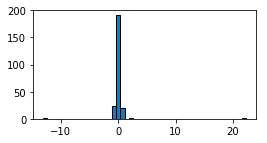

In [22]:
model1.best_model.resid.hist(bins=50, figsize=(4,2));
plt.grid(False)

Нулевая гипотеза о равенстве среднего нулю не отвергается. **Остатки — не смещены.**

In [23]:
sts.ttest_1samp(model1.best_model.resid.dropna(), 0)

Ttest_1sampResult(statistic=0.49127772987978024, pvalue=0.6236865888274754)

#### Стационарность остатков

Стационарность остатков проверим критерием Дики-Фуллера. Проверяется нулевая гипотеза:  
- $H_0:$ ряд нестационарен. Против общей альтернативы:  
- $H_1:$ ряд стационарен.

In [24]:
p_value = sm.tsa.stattools.adfuller(model1.best_model.resid.dropna())[1]
print(f'Dickey-Fuller test. p-value = : {p_value}')

Dickey-Fuller test. p-value = : 0.0


Нулевая гипотеза о нестационраности отвергается. **Остатки – стационарны.**

#### Неавтокоррелированность остатков

Из таблицы  summary() мы видим, что критерий Льюнга-Бокса, который проверяет неавтокоррелированность ошибок не отвергает гипотезу об отсутсвии автокорреляции (p-value = 0.76 > 0.05). Построим графики ошибок и кореллограмму остатков.

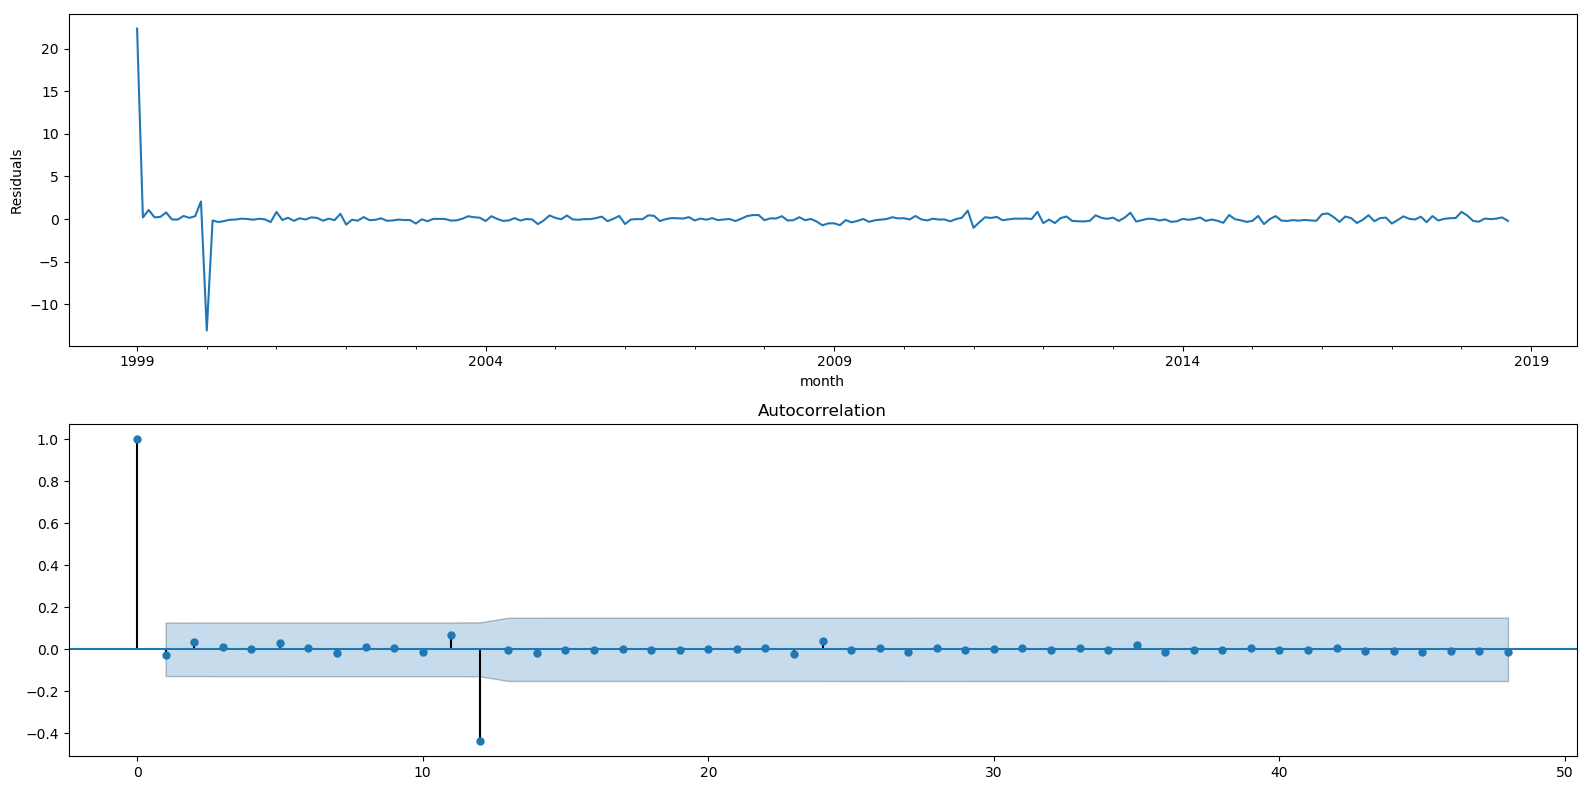

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), dpi=100)

model1.best_model.resid.plot(ax=ax[0]);
ax[0].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(model1.best_model.resid.dropna(), lags=48, ax=ax[1])

fig.tight_layout();

На графике виден один выброс, однако, в целом ошибки неавтокоррелированы, возможно выброс возник в результате вычислительной случайной ошибки в модели. Взглянем, насколько хорошо модель описывает имеющиеся данные.

Из графика наложения предсказанных и реальных значений видно, что на значительном отрезке отсрочки от сегодняшнего дня модель описывает данные хорошо. Предположим, что выброс случаен.

In [26]:
df['model'] = scipy.special.inv_boxcox(model1.best_model.fittedvalues, lmbda)

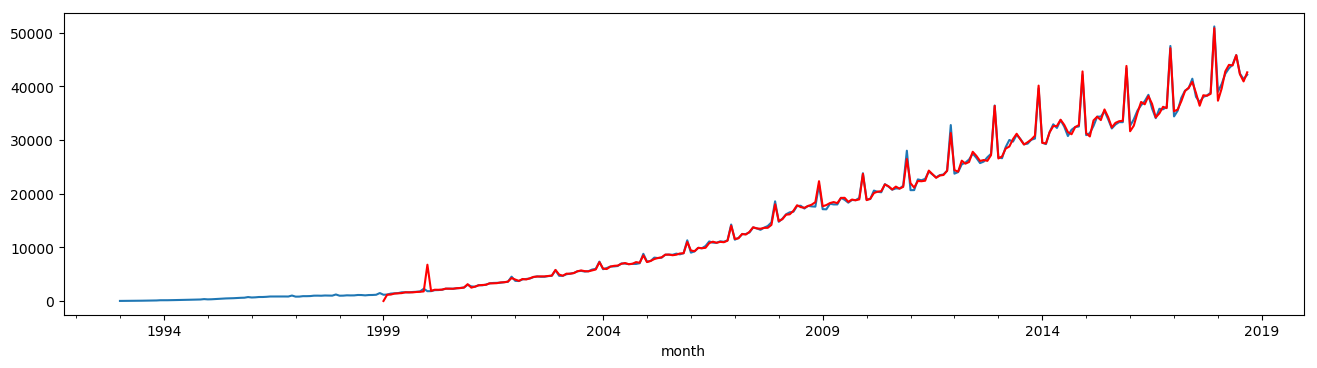

In [27]:
plt.figure(figsize=(16,4), dpi=100)

df.wage.plot();
df.model.plot(color='r');

## Прогноз

Теперь, когда мы подготовили модель и проверили её адеквастность при помощи анализа остатков, можно посмотреть как хорошо наша модель описывает данные.

In [28]:
import datetime
from dateutil.relativedelta import *

In [29]:
df_with_forecast = df[['wage']]
date_list = [
    datetime.datetime.strptime("2018-10-01", "%Y-%m-%d") + 
    relativedelta(months=x) for x in range(0,24)]

In [30]:
future = pd.DataFrame(
    index=date_list, columns=df_with_forecast.columns)

In [31]:
df_with_forecast = pd.concat([df_with_forecast, future])

In [32]:
df_with_forecast['forecast'] = scipy.special.inv_boxcox(
    model1.best_model.predict(start=237, end=261), lmbda)

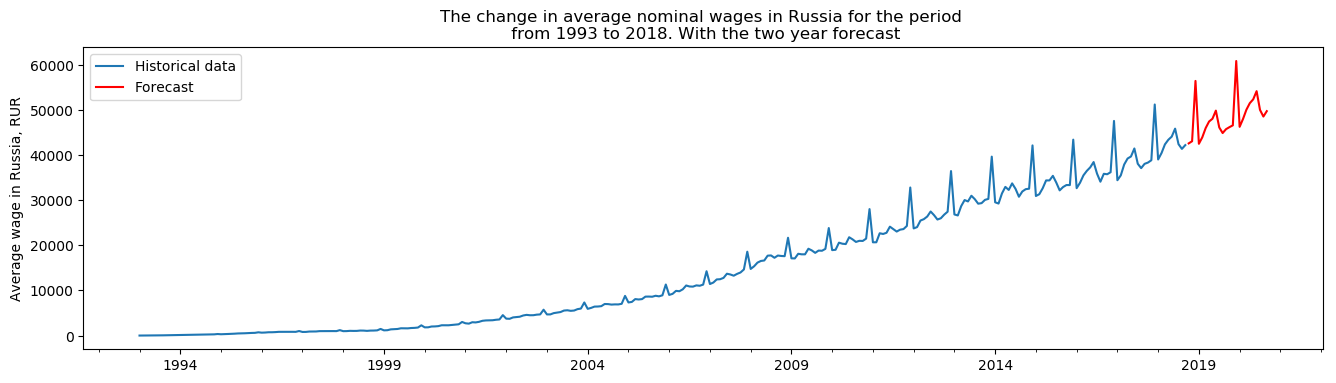

In [33]:
plt.figure(figsize=(16,4), dpi=100)

df_with_forecast.wage.plot(label='Historical data')
df_with_forecast.forecast.plot(color='r', label='Forecast')

plt.ylabel('Average wage in Russia, RUR')
plt.title('The change in average nominal wages in \
Russia for the period \n from 1993 to 2018. \
With the two year forecast')
plt.legend(loc='best');

## Выводы

Прогнозная модель показывает увеличение среднемесячной заработной платы. Однако стоит обратить внимание, на то что мы не корректировали уровень доходов на процент инфляции, поэтому для предсказания реальной средемесячной заработной платы наша прогнозная модель не годится. Скорее всего, она отражает продолжение роста инфляции. Однако, окончательный вывод должен делать специалист в предметной области.